In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from IPython.display import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('/content/Weather.csv')
data

,pickup_datetime,tempm,tempi,dewptm,dewpti,hum,wspdm,wspdi,wgustm,wgusti,...,precipm,precipi,conds,icon,fog,rain,snow,hail,thunder,tornado
0,2015-12-31 00:15:00,7.8,46.0,6.1,43.0,89.0,7.4,4.6,NaN,NaN,...,0.5,0.02,Light Rain,rain,0,1,0,0,0,0
1,2015-12-31 00:42:00,7.8,46.0,6.1,43.0,89.0,7.4,4.6,NaN,NaN,...,0.8,0.03,Overcast,cloudy,0,0,0,0,0,0
2,2015-12-31 00:51:00,7.8,46.0,6.1,43.0,89.0,5.6,3.5,NaN,NaN,...,0.8,0.03,Overcast,cloudy,0,0,0,0,0,0
3,2015-12-31 01:51:00,7.2,45.0,5.6,42.1,90.0,7.4,4.6,NaN,NaN,...,0.3,0.01,Overcast,cloudy,0,0,0,0,0,0
4,2015-12-31 02:51:00,7.2,45.0,5.6,42.1,90.0,0.0,0.0,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10476,2016-12-31 19:51:00,6.1,43.0,-4.4,24.1,47.0,7.4,4.6,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0
10477,2016-12-31 20:51:00,6.1,43.0,-4.4,24.1,47.0,13.0,8.1,38.9,24.2,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0
10478,2016-12-31 21:51:00,6.1,43.0,-5.0,23.0,45.0,9.3,5.8,29.6,18.4,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0
10479,2016-12-31 22:51:00,6.7,44.1,-5.0,23.0,43.0,14.8,9.2,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0


In [8]:
data.dtypes

pickup_datetime     object
tempm              float64
tempi              float64
dewptm             float64
dewpti             float64
hum                float64
wspdm              float64
wspdi              float64
wgustm             float64
wgusti             float64
wdird                int64
wdire               object
vism               float64
visi               float64
pressurem          float64
pressurei          float64
windchillm         float64
windchilli         float64
heatindexm         float64
heatindexi         float64
precipm            float64
precipi            float64
conds               object
icon                object
fog                  int64
rain                 int64
snow                 int64
hail                 int64
thunder              int64
tornado              int64
dtype: object

In [9]:
data.isnull().sum()

pickup_datetime       0
tempm                 5
tempi                 5
dewptm                5
dewpti                5
hum                   5
wspdm               737
wspdi               737
wgustm             8605
wgusti             8605
wdird                 0
wdire                 0
vism                245
visi                245
pressurem           239
pressurei           239
windchillm         7775
windchilli         7775
heatindexm         9644
heatindexi         9644
precipm            8775
precipi            8775
conds                 0
icon                  0
fog                   0
rain                  0
snow                  0
hail                  0
thunder               0
tornado               0
dtype: int64

In [22]:
# Пример работы MissingIndicator
temp_x1 = np.array([[np.nan, 1, 3], [np.nan, 0, 5], [3,np.nan, 1]])
print('Исходный массив:')
print(temp_x1)
indicator = MissingIndicator(features='all')
temp_x1_transformed = indicator.fit_transform(temp_x1)
print('Маска пропущенных значений:')
print(temp_x1_transformed)

Исходный массив:
[[nan  1.  3.]
 [nan  0.  5.]
 [ 3. nan  1.]]
Маска пропущенных значений:
[[ True False False]
 [ True False False]
 [False  True False]]


In [23]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]

    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)

    imputer = SimpleImputer(strategy=strategy_param,
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)

    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]

    return all_data.reshape((size,)), filled_data, missed_data

In [24]:
def research_impute_numeric_column(dataset, num_column, const_value=None):
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))

    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))

    new_df = pd.DataFrame({'Исходные данные':original_data})

    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy!='constant') or (strategy == 'constant' and const_value!=None):
            if strategy == 'constant':
                temp_data, _, _ = impute_column(dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data, _, _ = impute_column(dataset, num_column, strategy)
            new_df[col_name] = temp_data

    sns.kdeplot(data=new_df)

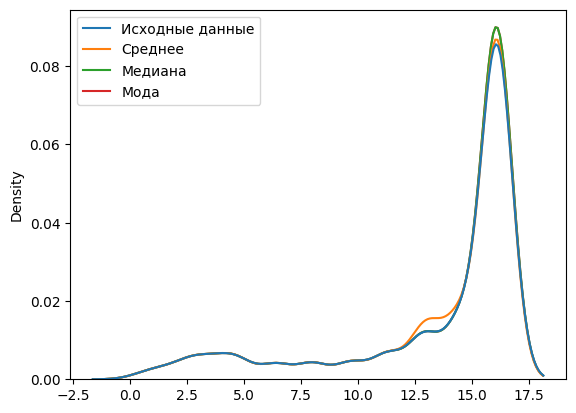

In [26]:
research_impute_numeric_column(data, 'vism')

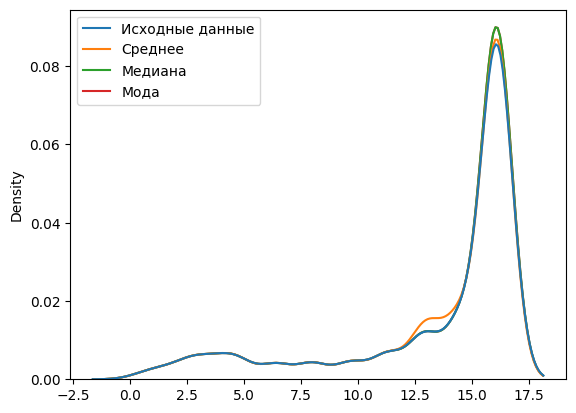

In [28]:
research_impute_numeric_column(data, 'vism')

# 2.	Кодирование категориальных признаков

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from IPython.display import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('/content/second_hand_car_sales.csv')
data

,Manufacturer,Model,Engine Size (L),Fuel Type,Year of Manufacture,Mileage,Price
0,Mercedes-Benz,Cruze,1.418475,Electric,2013,61837,34792
1,Toyota,A4,4.492330,Electric,2003,128993,27129
2,Audi,C-Class,4.739375,Electric,2000,81362,29141
3,Nissan,Model 3,3.128423,Petrol,2011,168204,24731
4,Mercedes-Benz,Golf,1.650279,Diesel,2006,119405,27493
...,...,...,...,...,...,...,...
49995,Chevrolet,Corolla,1.241130,Diesel,2021,163295,1110
49996,Nissan,Civic,3.741902,Electric,2012,85805,27877
49997,Toyota,Altima,2.501539,Hybrid,2016,187733,42132
49998,Ford,Model 3,2.066934,Electric,2022,136728,39121


In [54]:
data_dumm=data.copy(deep=True)
pd.get_dummies(data_dumm[['Manufacturer']], dummy_na=True).head()

,Manufacturer_Audi,Manufacturer_BMW,Manufacturer_Chevrolet,Manufacturer_Ford,Manufacturer_Honda,Manufacturer_Mercedes-Benz,Manufacturer_Nissan,Manufacturer_Tesla,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_nan
0,False,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,False
2,True,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,False


In [55]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    original_dataframe = pd.concat([original_dataframe, dummies], axis=1)
    original_dataframe = original_dataframe.drop(feature_to_encode,axis = 1)
    return original_dataframe

In [56]:
data_dumm=encode_and_bind(data_dumm, 'Manufacturer')
data_dumm.head()

,Model,Engine Size (L),Fuel Type,Year of Manufacture,Mileage,Price,Manufacturer_Audi,Manufacturer_BMW,Manufacturer_Chevrolet,Manufacturer_Ford,Manufacturer_Honda,Manufacturer_Mercedes-Benz,Manufacturer_Nissan,Manufacturer_Tesla,Manufacturer_Toyota,Manufacturer_Volkswagen
0,Cruze,1.418475,Electric,2013,61837,34792,False,False,False,False,False,True,False,False,False,False
1,A4,4.492330,Electric,2003,128993,27129,False,False,False,False,False,False,False,False,True,False
2,C-Class,4.739375,Electric,2000,81362,29141,True,False,False,False,False,False,False,False,False,False
3,Model 3,3.128423,Petrol,2011,168204,24731,False,False,False,False,False,False,True,False,False,False
4,Golf,1.650279,Diesel,2006,119405,27493,False,False,False,False,False,True,False,False,False,False


In [57]:
data=data.copy(deep=True)
!pip install category-encoders

In [58]:
from category_encoders.one_hot import OneHotEncoder as ce_OneHotEncoder
ce_OneHotEncoder1 = ce_OneHotEncoder()
data_OHE = ce_OneHotEncoder1.fit_transform(data[data.columns.difference(['Fuel Type'])])
data_OHE

,Engine Size (L),Manufacturer_1,Manufacturer_2,Manufacturer_3,Manufacturer_4,Manufacturer_5,Manufacturer_6,Manufacturer_7,Manufacturer_8,Manufacturer_9,...,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10,Price,Year of Manufacture
0,1.418475,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,34792,2013
1,4.492330,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,27129,2003
2,4.739375,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,29141,2000
3,3.128423,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,24731,2011
4,1.650279,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,27493,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1.241130,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1110,2021
49996,3.741902,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,27877,2012
49997,2.501539,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,42132,2016
49998,2.066934,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,39121,2022


# 3.	Нормализация числовых признаков


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

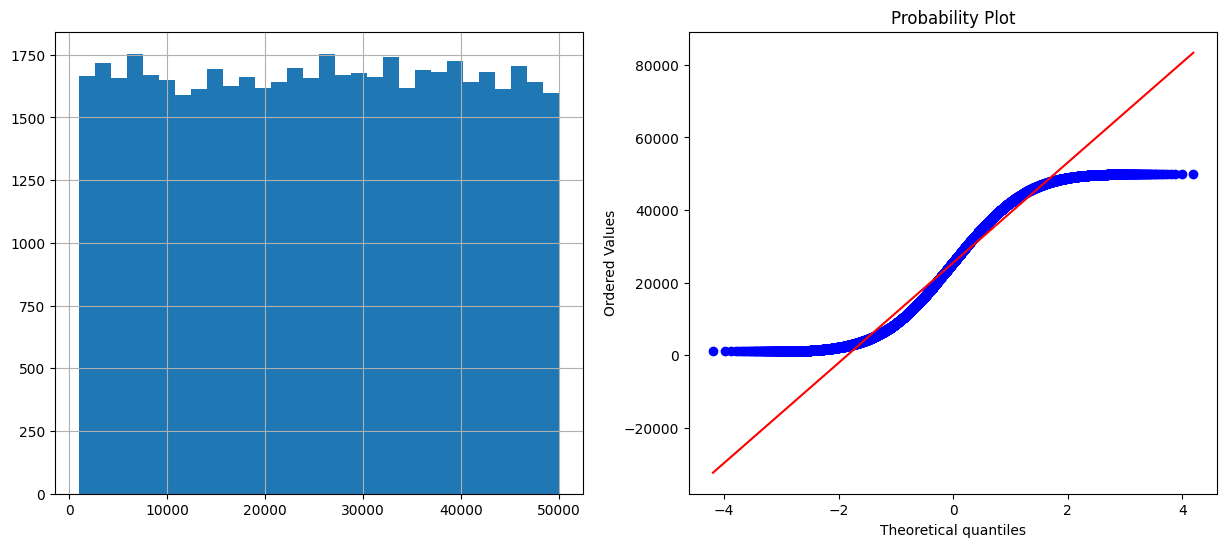

In [64]:
data = data.dropna(subset=['Price'],axis=0)
data = data[data['Price'] != 0]
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()
diagnostic_plots(data, 'Price')